# Import Lib

In [437]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import plotly.express as px
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Load

In [438]:
train_df = pd.read_json('../data/train.json')
test_df = pd.read_json('../data/test.json')

In [439]:
# Prepare list of all dist_subdist (district concat subdistrict)
dist_subdist_replacement = pd.read_csv('../data/dist_subdist_replacement.csv')
replacement_dict = dist_subdist_replacement.set_index('dist_subdist')['replacement'].to_dict()

train_df['dist_subdist'] = train_df['district'] + '_' + train_df['subdistrict'].map(lambda x: '' if x == None else x)
test_df['dist_subdist'] = test_df['district'] + '_' + test_df['subdistrict'].map(lambda x: '' if x == None else x)

all_dist_subdist = list(train_df['dist_subdist'].unique()) + list(test_df['dist_subdist'].unique())
all_dist_subdist = list(set(all_dist_subdist))

for i in range(len(all_dist_subdist)):
    if all_dist_subdist[i] in replacement_dict:
        all_dist_subdist[i] = 'dist_subdist_' + replacement_dict[all_dist_subdist[i]]
    else:
        all_dist_subdist[i] = 'dist_subdist_' + all_dist_subdist[i]

all_dist_subdist


['dist_subdist_Khlong Sam Wa_Bang Chan',
 'dist_subdist_Mueang Samut Prakan_Samrong Nuea',
 'dist_subdist_Phra Pradaeng_Samrong',
 'dist_subdist_Khlong Sam Wa_Sam Wa Tawan Tok',
 'dist_subdist_Sathon_Yan Nawa',
 'dist_subdist_Phasi Charoen_Khlong Khwang',
 'dist_subdist_Sathon_Thung Maha Mek',
 'dist_subdist_Nong Chok_Krathum Rai',
 'dist_subdist_Thon Buri_Bukkhalo',
 'dist_subdist_Bang Kruai_Bang Si Thong',
 'dist_subdist_Bangkok Yai_Wat Tha Phra',
 'dist_subdist_Bang Phli_Bang Phli Yai',
 'dist_subdist_Bueng Kum_Nuan Chan',
 'dist_subdist_Nong Khaem_Nong Khaem',
 'dist_subdist_Huai Khwang_Sam Sen Nok',
 'dist_subdist_Bang Kapi_Khlong Chan',
 'dist_subdist_Mueang Samut Prakan_Pak Nam',
 'dist_subdist_Bang Khae_Bang Khae',
 'dist_subdist_Rat Burana_Bang Pa Kok',
 'dist_subdist_Mueang Samut Prakan_Thai Ban',
 'dist_subdist_Chatuchak_Chan Kasem',
 'dist_subdist_Bang Phli_Bang Chalong',
 'dist_subdist_Bang Bua Thong_Phimon Rat',
 'dist_subdist_Bang Kapi_Hua Mak',
 'dist_subdist_Chatuchak_

# EDA & Clean

In [440]:
print(train_df.shape)
train_df.head()

(14271, 24)


,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price,dist_subdist
0,8448321,Bangkok,Watthana,Phra Khanong Nuea,"36 Soi Sukhumvit 63, Ekamai Road",Condo,273.0,2.0,2.0,66,...,2,"[[E7 Ekkamai BTS, 270], [E6 Thong Lo BTS, 800]]",NaN,16.0,20,2011,June,"[Car Park, Community Garden, CCTV, Fitness cor...",8500000,Watthana_Phra Khanong Nuea
1,10936325,Bangkok,Watthana,Khlong Toei Nuea,31 สุขุมวิท,Condo,74.0,1.0,1.0,49,...,3,"[[BL22 Sukhumvit MRT, 720], [BL21 Phetchaburi ...",NaN,11.0,20,2012,September,"[CCTV, Fitness corner, 24 hours security, Swim...",5900000,Watthana_Khlong Toei Nuea
2,10927931,Bangkok,Khlong Toei,Khlong Tan,"68 Sukhumvit 24 Alley, Khong Tan",Condo,940.0,1.0,1.0,34,...,2,"[[E5 Phrom Phong BTS, 650], [BL23 Queen Siriki...",NaN,20.0,20,2017,January,"[Car Park, Clubhouse, Community Garden, CCTV, ...",6290000,Khlong Toei_Khlong Tan
3,11004792,Nonthaburi,Bang Kruai,Bang Khun Kong,Bang Khun Kong,Detached House,NaN,3.0,3.0,170,...,0,None,NaN,2.0,4,0,None,"[Covered car park, Playground, 24 hours securi...",8900000,Bang Kruai_Bang Khun Kong
4,10757452,Nonthaburi,Mueang Nonthaburi,Bang Phai,พระราม5-นครอินทร์,Townhouse,NaN,3.0,2.0,120,...,1,"[[PP09 Yaek Nonthaburi 1 MRT, 10]]",NaN,6.0,15,0,None,"[Covered car park, 24 hours security]",2390000,Mueang Nonthaburi_Bang Phai


In [441]:
print(test_df.shape)
test_df.head()

(2500, 23)


,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,dist_subdist
0,10317868,Samut Prakan,Bang Phli,Bang Phli Yai,Nam Daeng Road Yai,Detached House,800.0,4.0,3.0,120,...,100.680610,0,None,NaN,9.0,5,0,None,"[Clubhouse, Community Garden, CCTV, Pavillion,...",Bang Phli_Bang Phli Yai
1,10885829,Bangkok,Nong Khaem,Nong Khang Phlu,Machareon Road,Detached House,107.0,4.0,3.0,188,...,100.341833,0,None,20.0,9.0,5,2020,None,"[Car Park, Clubhouse, Community Garden, CCTV, ...",Nong Khaem_Nong Khang Phlu
2,10765951,Bangkok,Huai Khwang,Huai Khwang,72 Rama 9,Condo,433.0,1.0,1.0,22,...,100.566385,3,"[[BL20 Phra Ram 9 MRT, 270], [E4 Asok BTS, 780...",NaN,13.0,20,2015,September,"[Covered car park, CCTV, Fitness corner, 24 ho...",Huai Khwang_Huai Khwang
3,10003549,Bangkok,Khlong Toei,Khlong Tan,"772 Sukhumvit Road, Khong Tan",Condo,656.0,1.0,1.0,41,...,100.577202,1,"[[E6 Thong Lo BTS, 70]]",20.0,16.0,20,2013,June,"[Car Park, Covered car park, CCTV, Fitness cor...",Khlong Toei_Khlong Tan
4,10663026,Bangkok,Lak Si,Thung Song Hong,222 Ngamwongwan Road,Condo,1458.0,1.0,1.0,29,...,100.547923,0,None,20.0,10.0,14,2012,September,"[Covered car park, CCTV, Fitness corner, 24 ho...",Lak Si_Thung Song Hong


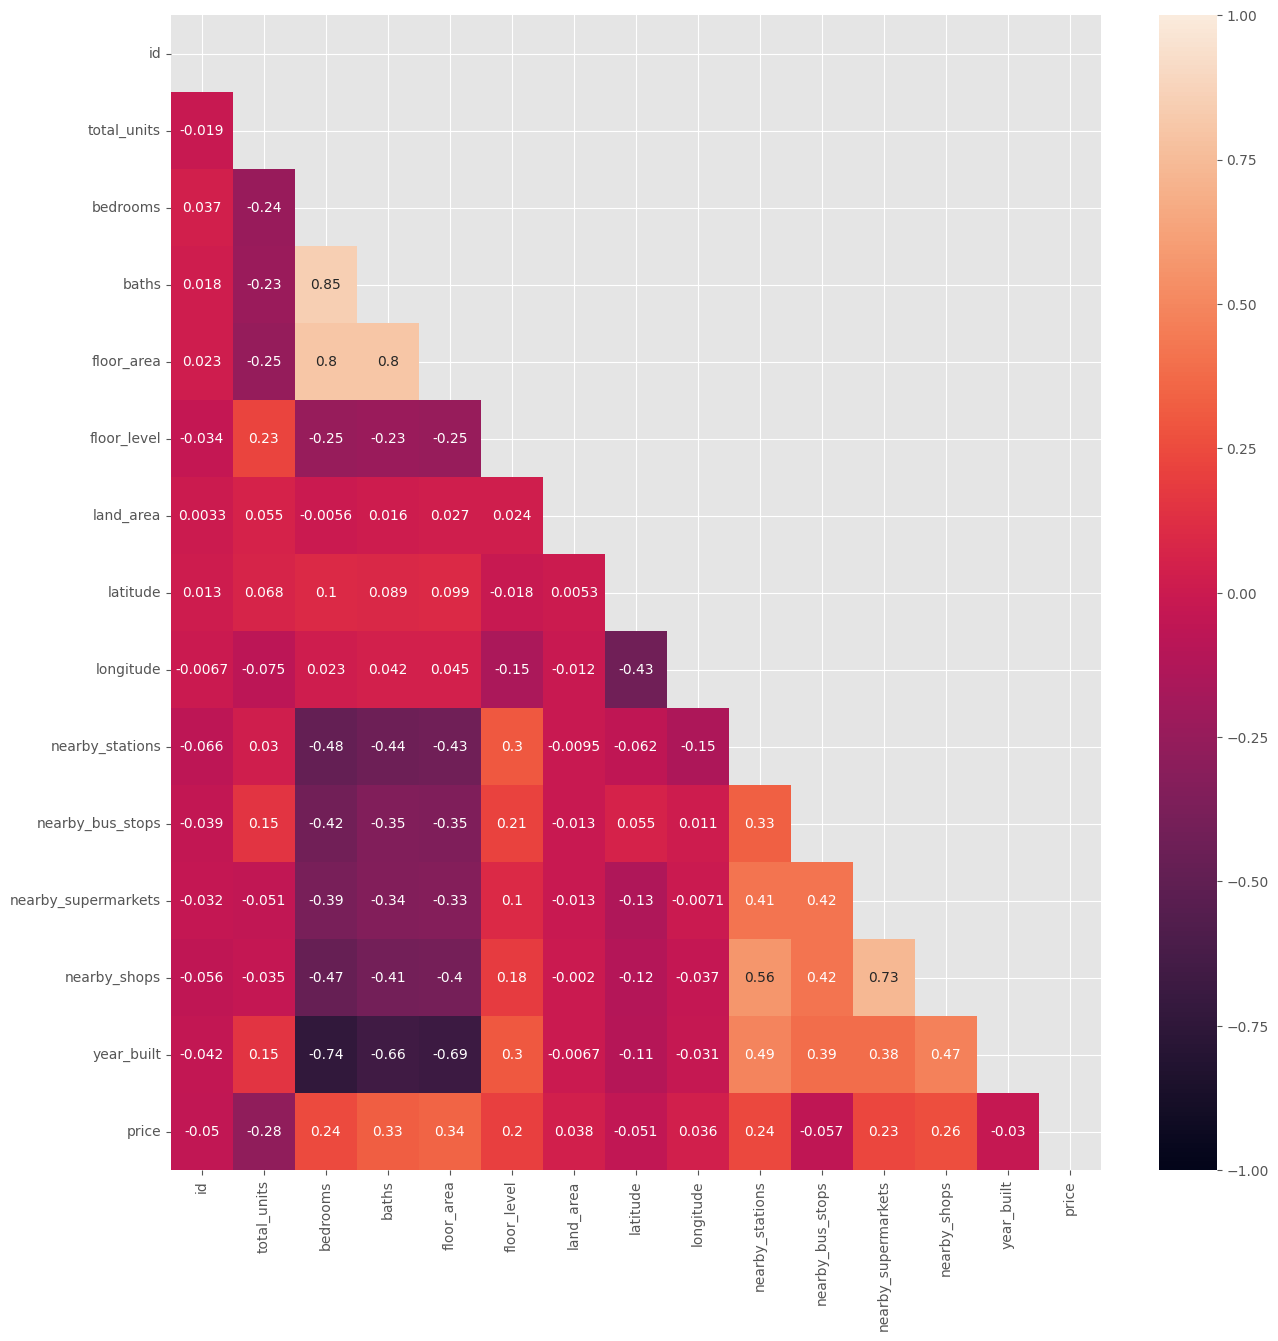

In [442]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(train_df.corr(numeric_only=True)), k=0)
sns.heatmap(train_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, mask=mask);

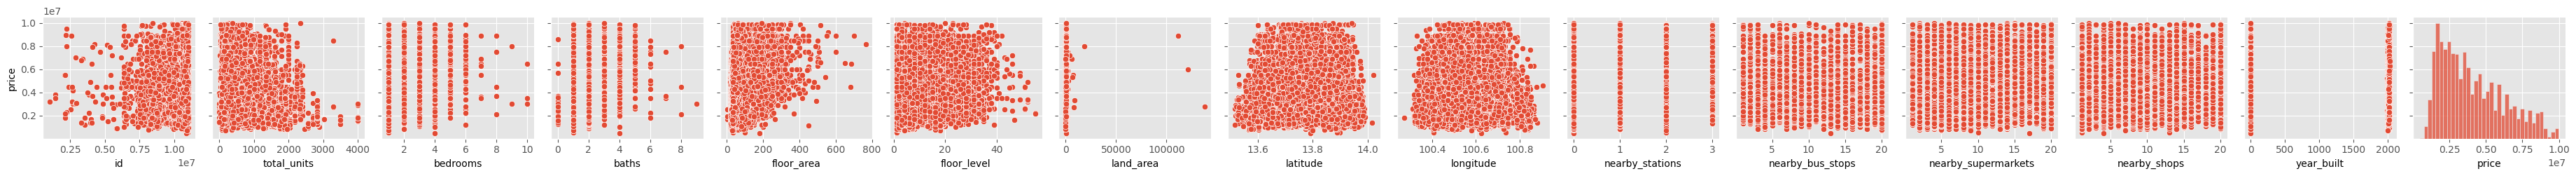

In [443]:
sns.pairplot(data=train_df._get_numeric_data(), y_vars='price');

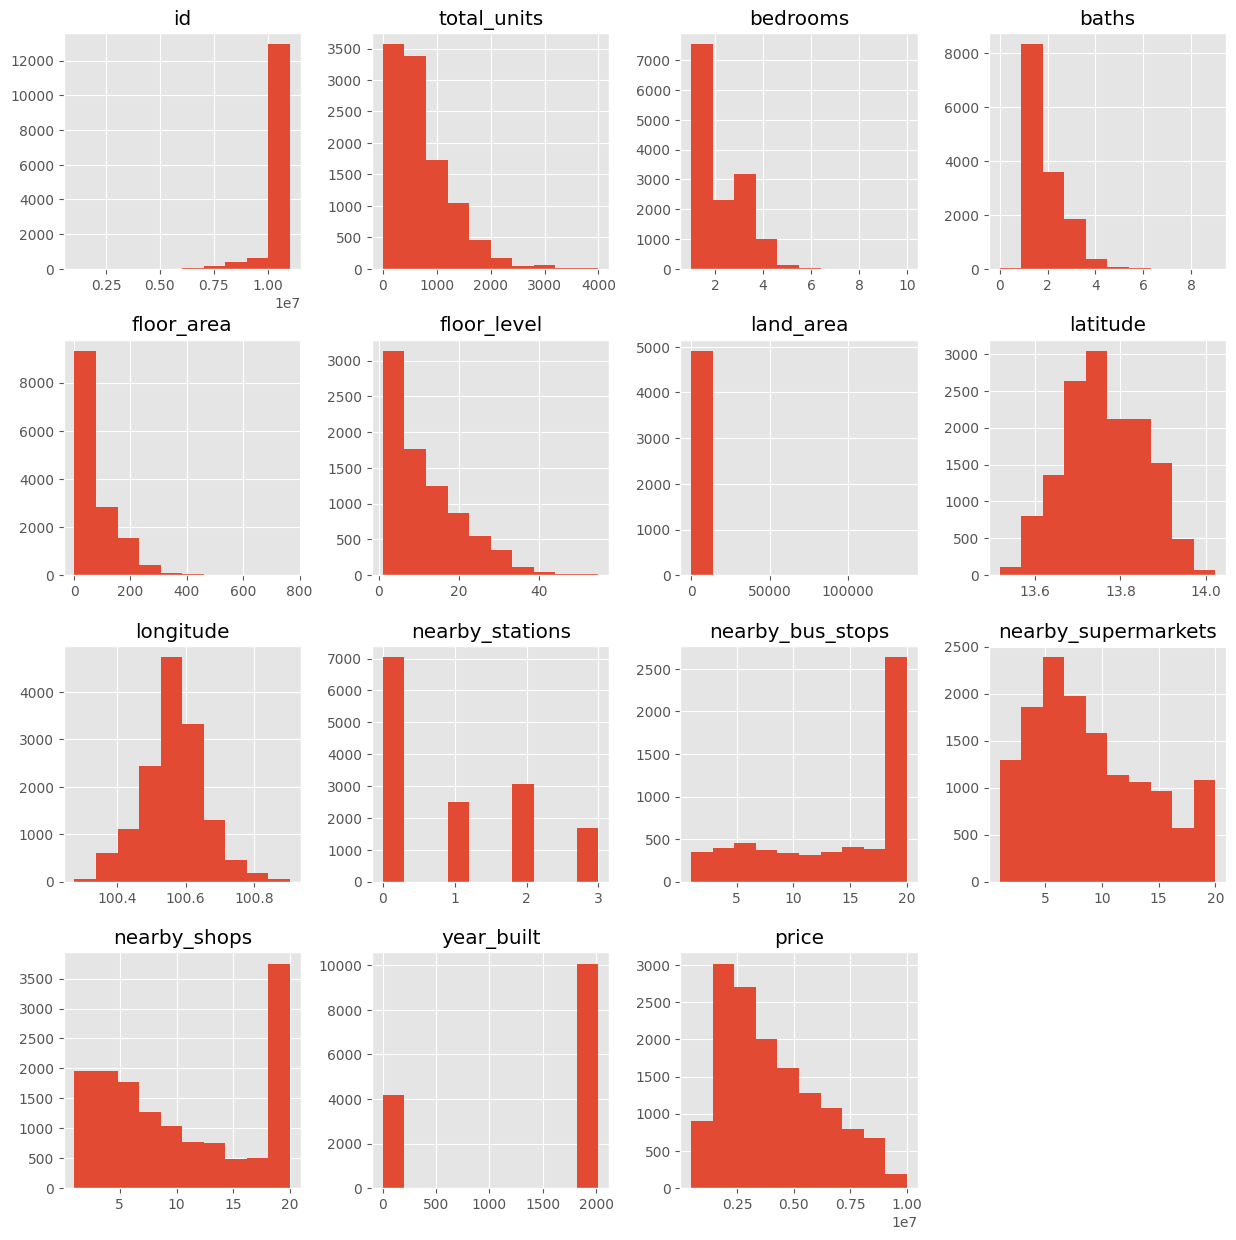

In [444]:
train_df.hist(figsize=(15,15));

C:\Users\icyge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


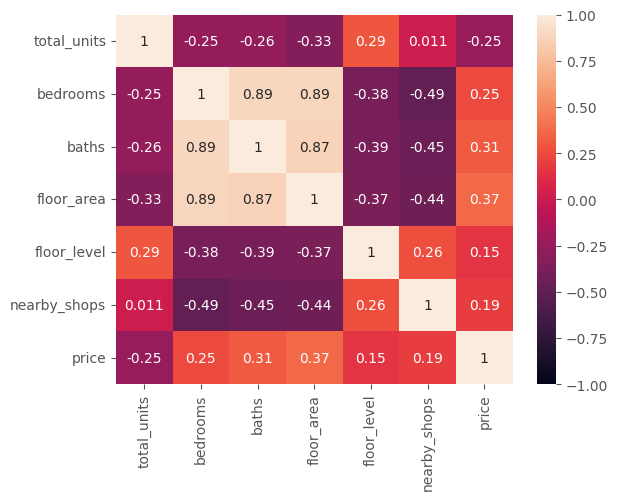

In [445]:
# Test taking log on skewed features
temp_df = np.log(train_df[['total_units', 'bedrooms', 'baths', 'floor_area', 'floor_level', 'nearby_shops']])
temp_df = pd.concat([temp_df, train_df['price']], axis=1)
sns.heatmap(temp_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True);
del temp_df

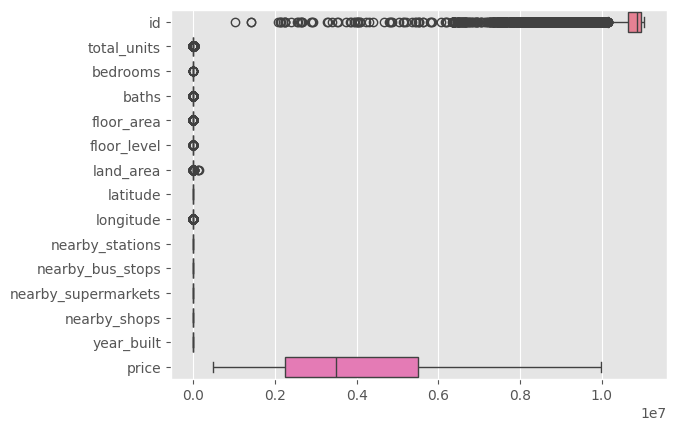

In [446]:
sns.boxplot(train_df._get_numeric_data(), orient='h');

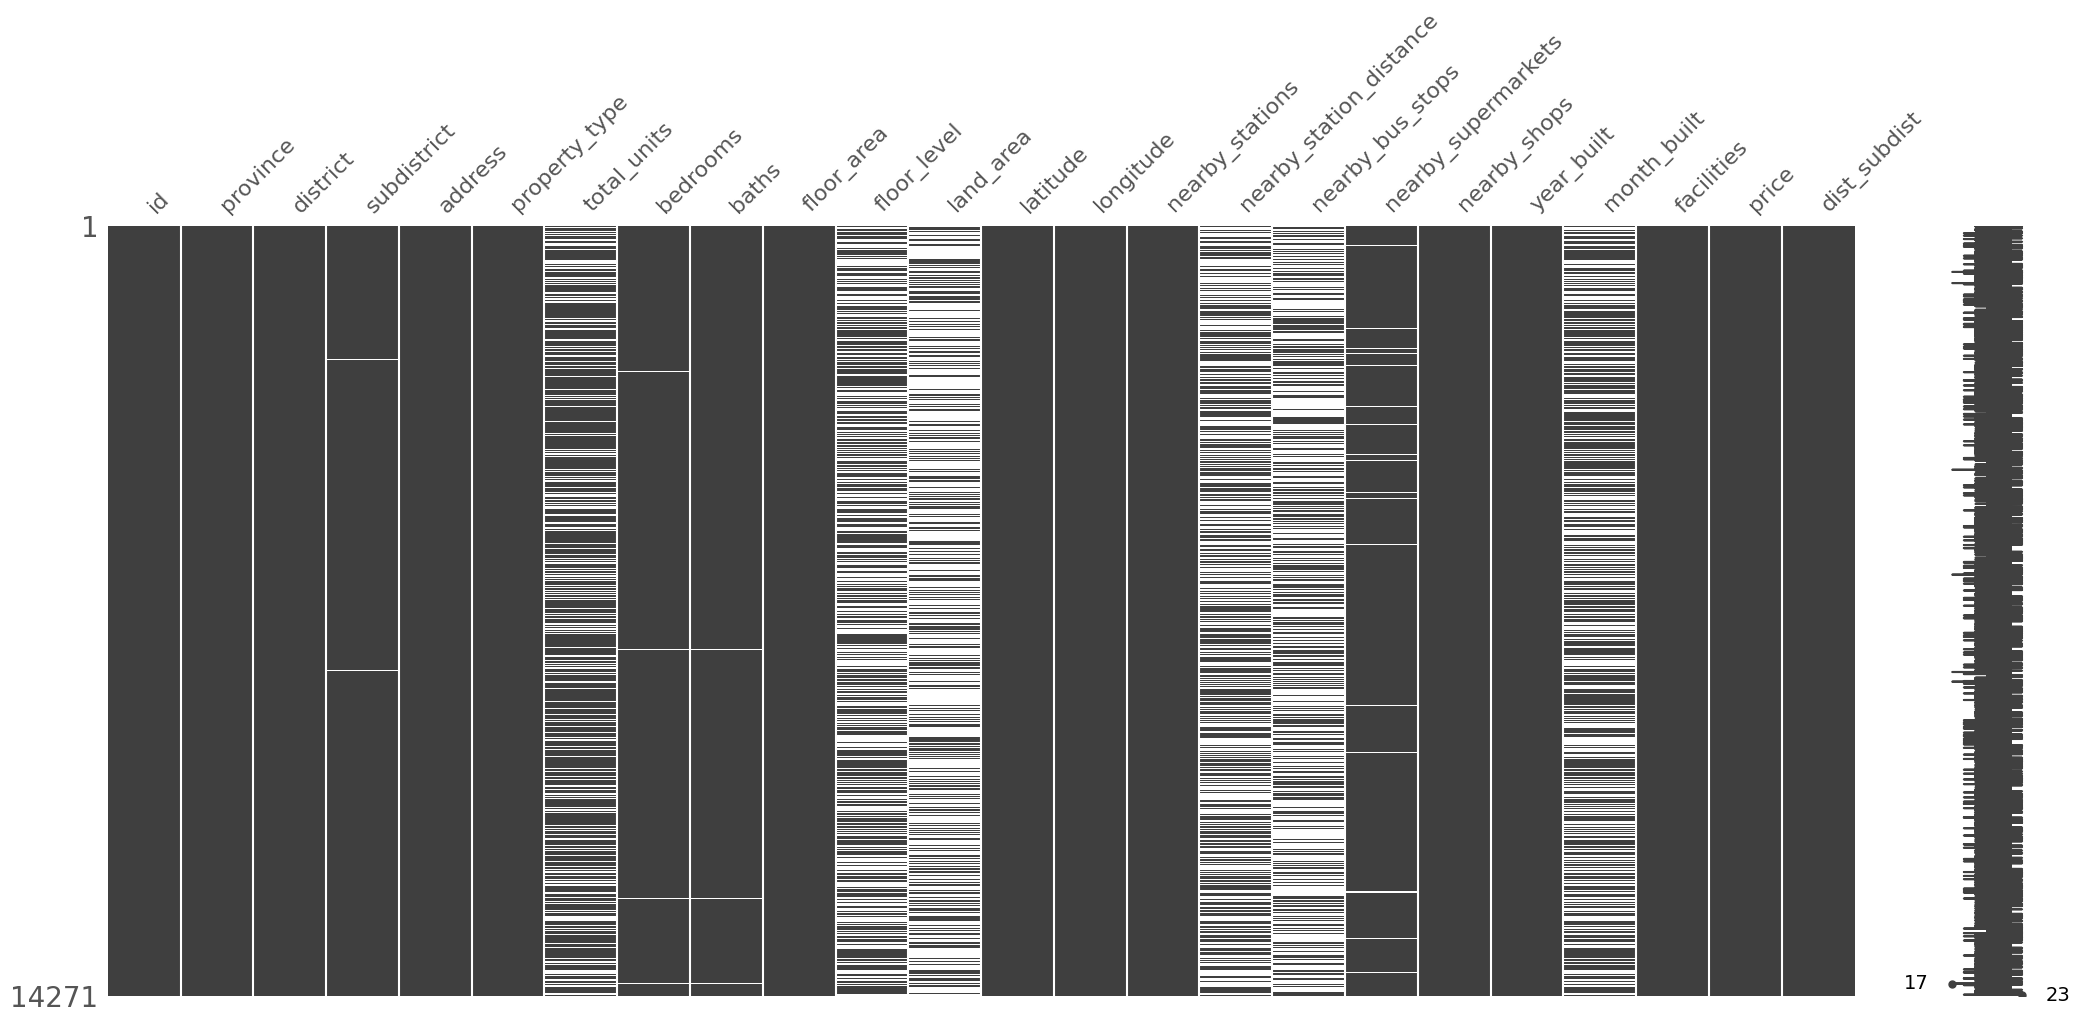

In [447]:
msno.matrix(train_df);

In [448]:
# Check values of each column
for feature in train_df.columns:
    print(feature)
    try:
        print(train_df[feature].sort_values(ascending=False).unique())
    except:
        print(train_df[feature].astype(str).sort_values(ascending=False).unique())
    print('\n')

id
[11047896 11047889 11047888 ...  1422670  1421378  1025114]


province
['Samut Prakan' 'Nonthaburi' 'Bangkok']


district
['Yan Nawa' 'Watthana' 'Wang Thonglang' 'Thung Khru' 'Thon Buri'
 'Thawi Watthana' 'Taling Chan' 'Suan Luang' 'Sathon' 'Saphan Sung'
 'Sai Noi' 'Sai Mai' 'Ratchathewi' 'Rat Burana' 'Prawet'
 'Phra Samut Jadee' 'Phra Pradaeng' 'Phra Khanong' 'Phaya Thai'
 'Phasi Charoen' 'Pathum Wan' 'Pak Kret' 'Nong Khaem' 'Nong Chok'
 'Mueang Samut Prakan' 'Mueang Nonthaburi' 'Min Buri' 'Lat Phrao'
 'Lat Krabang' 'Lak Si' 'Khlong Toei' 'Khlong San' 'Khlong Sam Wa'
 'Khan Na Yao' 'Huai Khwang' 'Don Mueang' 'Din Daeng' 'Chom Thong'
 'Chatuchak' 'Bueng Kum' 'Bangkok Yai' 'Bangkok Noi' 'Bang Yai' 'Bang Sue'
 'Bang Sao Thong' 'Bang Rak' 'Bang Phli' 'Bang Phlat' 'Bang Na'
 'Bang Kruai' 'Bang Khun Thian' 'Bang Kho Laem' 'Bang Khen' 'Bang Khae'
 'Bang Kapi' 'Bang Bua Thong' 'Bang Bon' 'Bang Bo']


subdistrict
['Yan Nawa' 'Wong Sawang' 'Whizdom The Exclusive' 'Wat Tha Phra'
 'Wat Phraya 

In [449]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14271 entries, 0 to 14270
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       14271 non-null  int64  
 1   province                 14271 non-null  object 
 2   district                 14271 non-null  object 
 3   subdistrict              14260 non-null  object 
 4   address                  14271 non-null  object 
 5   property_type            14271 non-null  object 
 6   total_units              10509 non-null  float64
 7   bedrooms                 14228 non-null  float64
 8   baths                    14236 non-null  float64
 9   floor_area               14271 non-null  int64  
 10  floor_level              8093 non-null   float64
 11  land_area                4917 non-null   float64
 12  latitude                 14271 non-null  float64
 13  longitude                14271 non-null  float64
 14  nearby_stations       

In [450]:
# Drop null in bedrooms and baths
train_df_imputed = train_df.copy()
train_df_imputed = train_df_imputed.loc[~(train_df_imputed['bedrooms'].isna()) & ~(train_df_imputed['baths'].isna())]
print(train_df_imputed.shape)
train_df_imputed.isna().sum()

(14226, 24)


id                            0
province                      0
district                      0
subdistrict                  11
address                       0
property_type                 0
total_units                3742
bedrooms                      0
baths                         0
floor_area                    0
floor_level                6146
land_area                  9329
latitude                      0
longitude                     0
nearby_stations               0
nearby_station_distance    7014
nearby_bus_stops           8240
nearby_supermarkets         383
nearby_shops                  0
year_built                    0
month_built                5851
facilities                    0
price                         0
dist_subdist                  0
dtype: int64

In [451]:
# Deal with null values

# Impute total_units with indicator
from sklearn.impute import KNNImputer

knn_imp = KNNImputer(add_indicator=True)

col_imputed_with_ind = knn_imp.fit_transform(train_df_imputed[['total_units']])
train_df_imputed['total_units'] = col_imputed_with_ind[:,0]
train_df_imputed['total_units_missing'] = col_imputed_with_ind[:,1]
train_df_imputed.isna().sum()

# Prepare model for imputing bedrooms, baths and nearby_supermarkets in test data
knn_imp_2 = KNNImputer()
knn_imp_2.fit(train_df_imputed[['bedrooms', 'baths', 'nearby_supermarkets']])

KNNImputer()

In [452]:
# Check missing floor_level pattern
train_df_imputed.loc[train_df_imputed['floor_level'].isna()].drop(columns=['id', 'address', 'subdistrict', 'month_built', 'latitude', 'longitude']).head()

,province,district,property_type,total_units,bedrooms,baths,floor_area,floor_level,land_area,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,facilities,price,dist_subdist,total_units_missing
3,Nonthaburi,Bang Kruai,Detached House,712.42913,3.0,3.0,170,NaN,248.0,0,None,NaN,2.0,4,0,"[Covered car park, Playground, 24 hours securi...",8900000,Bang Kruai_Bang Khun Kong,1.0
4,Nonthaburi,Mueang Nonthaburi,Townhouse,712.42913,3.0,2.0,120,NaN,72.0,1,"[[PP09 Yaek Nonthaburi 1 MRT, 10]]",NaN,6.0,15,0,"[Covered car park, 24 hours security]",2390000,Mueang Nonthaburi_Bang Phai,1.0
7,Bangkok,Sai Mai,Townhouse,712.42913,2.0,2.0,105,NaN,72.0,0,None,NaN,6.0,6,0,[Covered car park],1990000,Sai Mai_Sai Mai,1.0
11,Samut Prakan,Mueang Samut Prakan,Townhouse,712.42913,3.0,3.0,108,NaN,132.0,0,None,NaN,13.0,6,0,[24 hours security],3230000,Mueang Samut Prakan_Thepharak,1.0
12,Bangkok,Prawet,Townhouse,712.42913,4.0,2.0,117,NaN,76.0,0,None,3.0,1.0,4,0,[],3600000,Prawet_Dok Mai,1.0


In [453]:
train_df_imputed.loc[train_df_imputed['floor_level'].isna(), 'property_type'].drop(columns=['id', 'address', 'subdistrict', 'month_built', 'latitude', 'longitude']).unique()

array(['Detached House', 'Townhouse', 'Condo'], dtype=object)

In [454]:
print('Detached House\n', train_df_imputed.loc[train_df_imputed['property_type'] == 'Detached House', 'floor_level'].unique())
print('Townhouse\n', train_df_imputed.loc[train_df_imputed['property_type'] == 'Townhouse', 'floor_level'].unique())
print('Condo\n', train_df_imputed.loc[train_df_imputed['property_type'] == 'Condo', 'floor_level'].unique())

Detached House
 [nan  2.  3.  1.  4.  7. 13. 12. 24.]
Townhouse
 [nan  2.  1.  3.  4.  5. 12.]
Condo
 [10.  8.  4.  6. 12. 11.  2. 24. nan  5. 16. 14. 18. 15. 21. 39.  3. 32.
 17.  7. 25. 29. 26. 22.  9. 31. 46. 20. 19. 27.  1. 13. 30. 23. 28. 33.
 37. 40. 36. 55. 35. 51. 49. 34. 41. 38. 47. 43. 45. 44. 42. 52.]


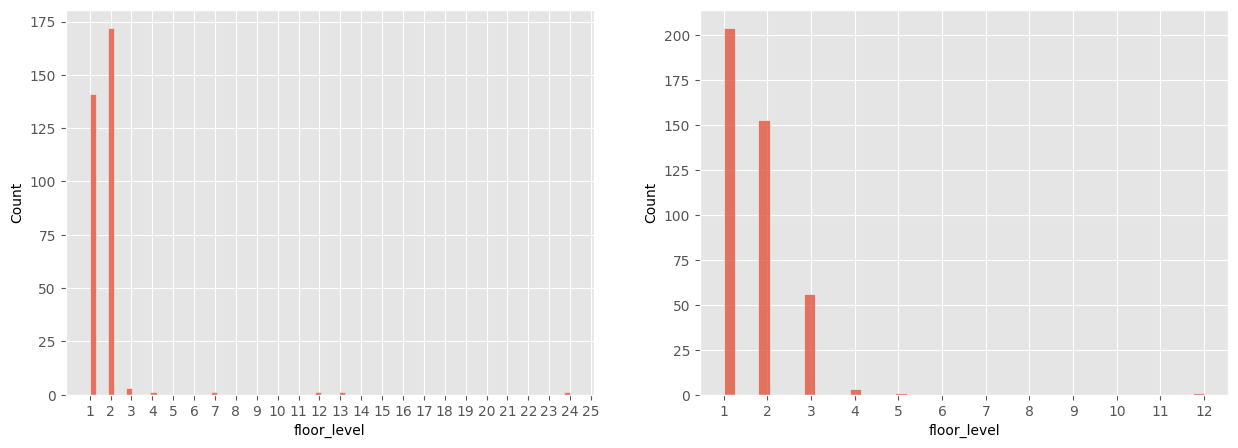

In [455]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df_imputed.loc[train_df_imputed['property_type'] == 'Detached House', 'floor_level'])
plt.xticks(range(1, 26))

plt.subplot(1, 2, 2)
sns.histplot(train_df_imputed.loc[train_df_imputed['property_type'] == 'Townhouse', 'floor_level'])
plt.xticks(range(1, 13));

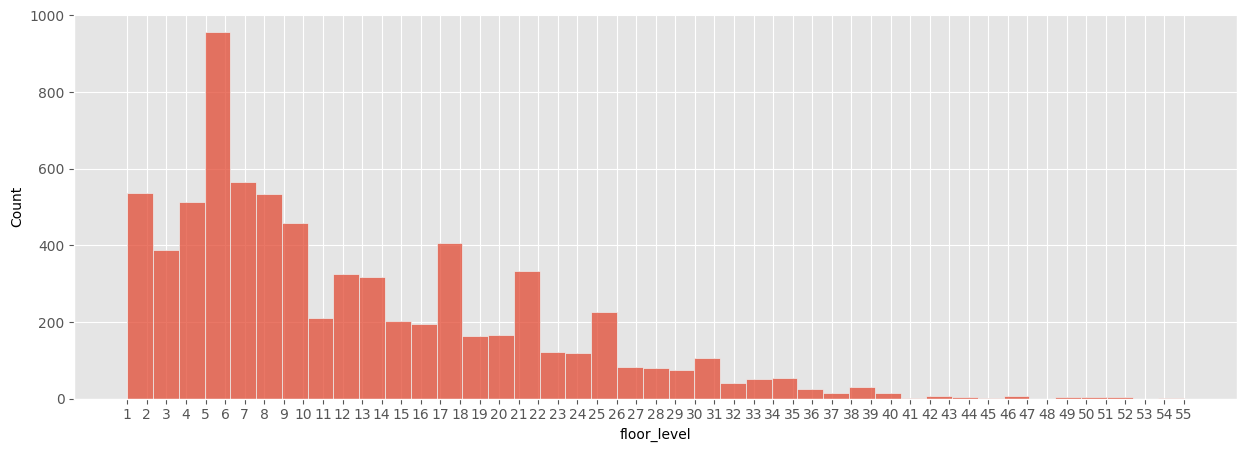

In [456]:
plt.figure(figsize=(15, 5))
sns.histplot(train_df_imputed.loc[train_df_imputed['property_type'] == 'Condo', 'floor_level']);
plt.xticks(range(1, 56));

In [457]:
# Impute floor_level using mean of each category
dhouse_mean = train_df_imputed.loc[train_df_imputed['property_type'] == 'Detached House', 'floor_level'].mean()
townhouse_mean = train_df_imputed.loc[train_df_imputed['property_type'] == 'Townhouse', 'floor_level'].mean()
condo_mean = train_df_imputed.loc[train_df_imputed['property_type'] == 'Condo', 'floor_level'].mean()

def impute_floor_level_with_indicator(row):
    if row['property_type'] == 'Detached House' and pd.isna(row['floor_level']):
        row['floor_level'] = dhouse_mean
        row['floor_level_missing'] = 1
    elif row['property_type'] == 'Townhouse' and pd.isna(row['floor_level']):
        row['floor_level'] = townhouse_mean
        row['floor_level_missing'] = 1
    elif row['property_type'] == 'Condo' and pd.isna(row['floor_level']):
        row['floor_level'] = condo_mean
        row['floor_level_missing'] = 1
    else:
        row['floor_level_missing'] = 0
    return row

train_df_imputed = train_df_imputed.apply(impute_floor_level_with_indicator, axis=1)
train_df_imputed.isna().sum()

id                            0
province                      0
district                      0
subdistrict                  11
address                       0
property_type                 0
total_units                   0
bedrooms                      0
baths                         0
floor_area                    0
floor_level                   0
land_area                  9329
latitude                      0
longitude                     0
nearby_stations               0
nearby_station_distance    7014
nearby_bus_stops           8240
nearby_supermarkets         383
nearby_shops                  0
year_built                    0
month_built                5851
facilities                    0
price                         0
dist_subdist                  0
total_units_missing           0
floor_level_missing           0
dtype: int64

In [458]:
# Drop null in nearby_supermarkets
train_df_imputed = train_df_imputed.loc[~(train_df_imputed['nearby_supermarkets'].isna())]
print(train_df_imputed.shape)
train_df_imputed.isna().sum()

(13843, 26)


id                            0
province                      0
district                      0
subdistrict                  11
address                       0
property_type                 0
total_units                   0
bedrooms                      0
baths                         0
floor_area                    0
floor_level                   0
land_area                  9270
latitude                      0
longitude                     0
nearby_stations               0
nearby_station_distance    6644
nearby_bus_stops           7984
nearby_supermarkets           0
nearby_shops                  0
year_built                    0
month_built                5536
facilities                    0
price                         0
dist_subdist                  0
total_units_missing           0
floor_level_missing           0
dtype: int64

In [459]:
# Drop unused columns
# train_df_imputed.drop(columns=['id', 'address', 'subdistrict', 'month_built', 'latitude', 'longitude', 'land_area', 'nearby_bus_stop'], inplace=True)

In [460]:
# Correcting and transform district and subdistrict
dist_subdist_replacement = pd.read_csv('../data/dist_subdist_replacement.csv')
replacement_dict = dist_subdist_replacement.set_index('dist_subdist')['replacement'].to_dict()

train_df_imputed['dist_subdist'] = train_df_imputed['district'] + '_' + train_df_imputed['subdistrict'].map(lambda x: '' if x == None else x)
train_df_imputed['dist_subdist'] = train_df_imputed['dist_subdist'].replace(replacement_dict)

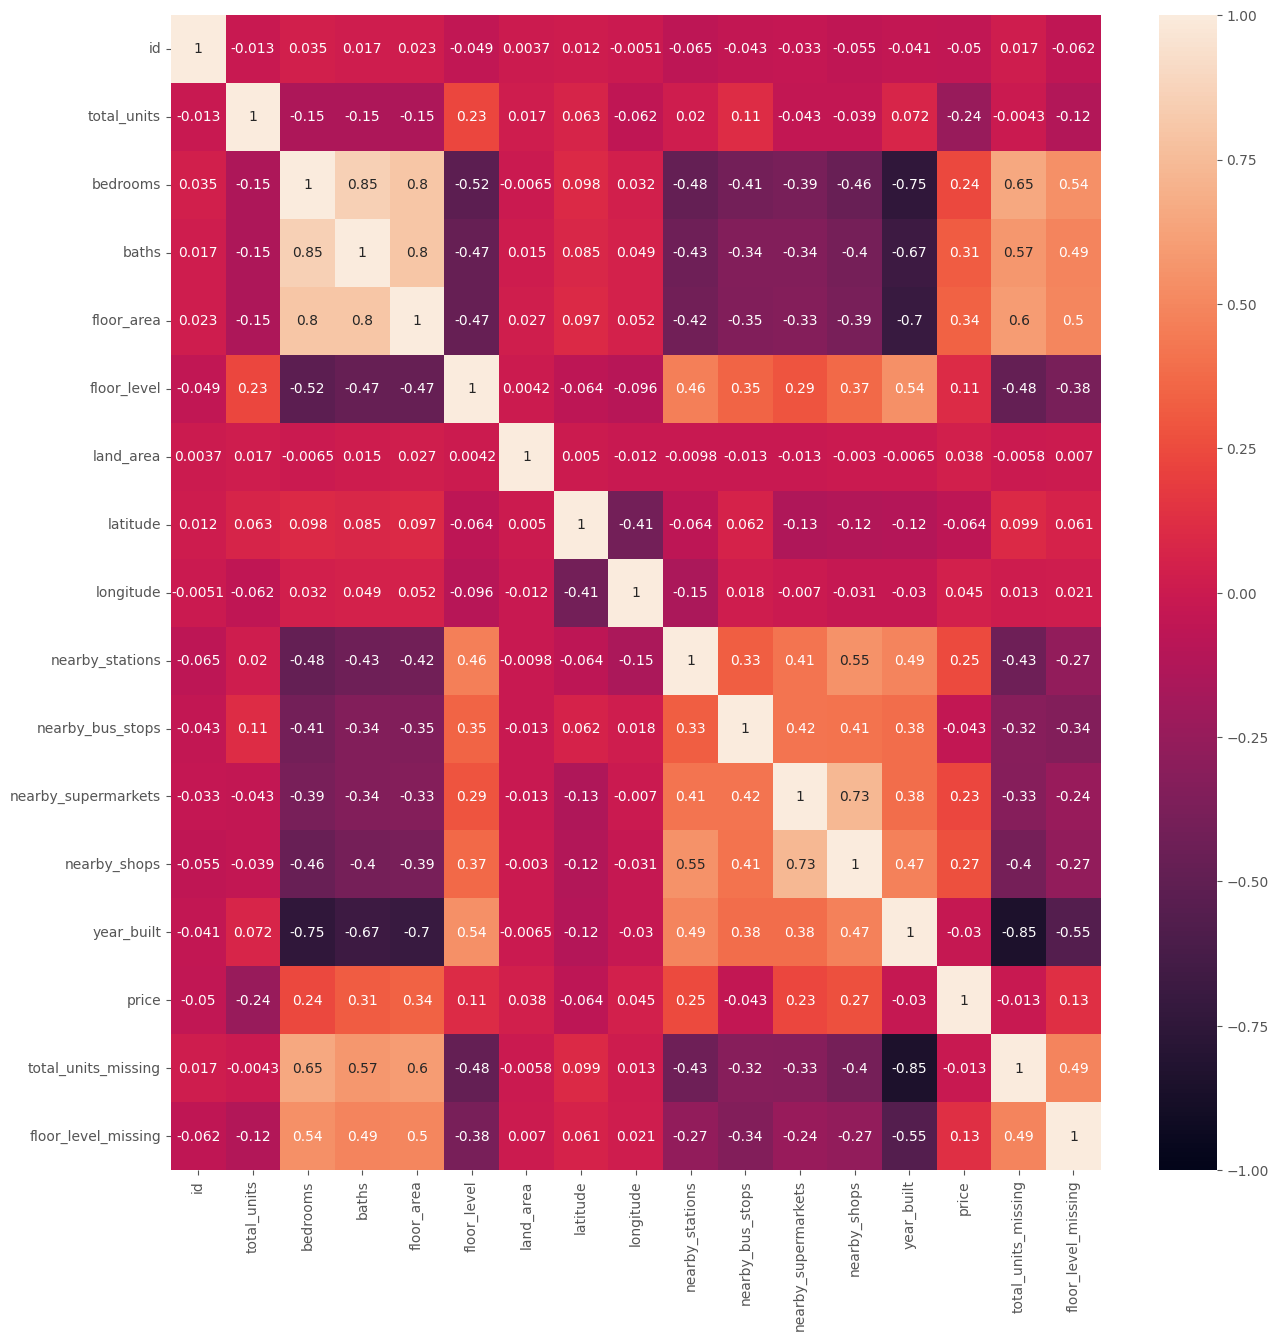

In [461]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df_imputed.corr(numeric_only=True), vmin=-1, vmax=1, annot=True);

In [462]:
# Get list of nearby stations
station_list = set()
for row in train_df_imputed['nearby_station_distance']:
    try:
        for station in row:
            station_list.add(station[0])
    except:
        pass

station_list = list(station_list)

In [463]:
# Set inital value of station columns = 0

for station in station_list:
    train_df_imputed[station] = 0

train_df_imputed

C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\1854006649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_imputed[station] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\1854006649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_imputed[station] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\1854006649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,RW06 SRT Taling Chan,BL32 Itsaraphap MRT,A6 Makkasan Airport Link,N24 Khu Khot BTS,N9 Ha Yaek Lat Phrao BTS,BL36 Phasi Charoen MRT,E1 Chit Lom BTS,BL02 Charan 13 MRT,S3 Chong Nonsi BTS,RW05 SRT Bang Bamru
0,8448321,Bangkok,Watthana,Phra Khanong Nuea,"36 Soi Sukhumvit 63, Ekamai Road",Condo,273.00000,2.0,2.0,66,...,0,0,0,0,0,0,0,0,0,0
1,10936325,Bangkok,Watthana,Khlong Toei Nuea,31 สุขุมวิท,Condo,74.00000,1.0,1.0,49,...,0,0,0,0,0,0,0,0,0,0
2,10927931,Bangkok,Khlong Toei,Khlong Tan,"68 Sukhumvit 24 Alley, Khong Tan",Condo,940.00000,1.0,1.0,34,...,0,0,0,0,0,0,0,0,0,0
3,11004792,Nonthaburi,Bang Kruai,Bang Khun Kong,Bang Khun Kong,Detached House,712.42913,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
4,10757452,Nonthaburi,Mueang Nonthaburi,Bang Phai,พระราม5-นครอินทร์,Townhouse,712.42913,3.0,2.0,120,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,10738911,Nonthaburi,Mueang Nonthaburi,Bang Kraso,36/2 รัตนาธิเบศร์,Condo,648.00000,2.0,1.0,58,...,0,0,0,0,0,0,0,0,0,0
14267,11031178,Nonthaburi,Bang Bua Thong,Phimon Rat,Phimonrat,Townhouse,712.42913,3.0,2.0,85,...,0,0,0,0,0,0,0,0,0,0
14268,10945909,Bangkok,Saphan Sung,Saphan Sung,Soi Ramkhamhaeng 164,Detached House,300.00000,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
14269,10768246,Bangkok,Don Mueang,Sanam Bin,วิภาวดีรังสิต,Townhouse,712.42913,2.0,2.0,150,...,0,0,0,0,0,0,0,0,0,0


In [464]:
# Convert nearby station and its distance to column
def extract_and_convert_nearby_station_to_column(row):
    try:
        for station in row['nearby_station_distance']:
            row[station[0]] = station[1]
    except:
        pass
    return row

train_df_imputed = train_df_imputed.apply(extract_and_convert_nearby_station_to_column, axis=1)
train_df_imputed

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,RW06 SRT Taling Chan,BL32 Itsaraphap MRT,A6 Makkasan Airport Link,N24 Khu Khot BTS,N9 Ha Yaek Lat Phrao BTS,BL36 Phasi Charoen MRT,E1 Chit Lom BTS,BL02 Charan 13 MRT,S3 Chong Nonsi BTS,RW05 SRT Bang Bamru
0,8448321,Bangkok,Watthana,Phra Khanong Nuea,"36 Soi Sukhumvit 63, Ekamai Road",Condo,273.00000,2.0,2.0,66,...,0,0,0,0,0,0,0,0,0,0
1,10936325,Bangkok,Watthana,Khlong Toei Nuea,31 สุขุมวิท,Condo,74.00000,1.0,1.0,49,...,0,0,0,0,0,0,0,0,0,0
2,10927931,Bangkok,Khlong Toei,Khlong Tan,"68 Sukhumvit 24 Alley, Khong Tan",Condo,940.00000,1.0,1.0,34,...,0,0,0,0,0,0,0,0,0,0
3,11004792,Nonthaburi,Bang Kruai,Bang Khun Kong,Bang Khun Kong,Detached House,712.42913,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
4,10757452,Nonthaburi,Mueang Nonthaburi,Bang Phai,พระราม5-นครอินทร์,Townhouse,712.42913,3.0,2.0,120,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,10738911,Nonthaburi,Mueang Nonthaburi,Bang Kraso,36/2 รัตนาธิเบศร์,Condo,648.00000,2.0,1.0,58,...,0,0,0,0,0,0,0,0,0,0
14267,11031178,Nonthaburi,Bang Bua Thong,Phimon Rat,Phimonrat,Townhouse,712.42913,3.0,2.0,85,...,0,0,0,0,0,0,0,0,0,0
14268,10945909,Bangkok,Saphan Sung,Saphan Sung,Soi Ramkhamhaeng 164,Detached House,300.00000,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
14269,10768246,Bangkok,Don Mueang,Sanam Bin,วิภาวดีรังสิต,Townhouse,712.42913,2.0,2.0,150,...,0,0,0,0,0,0,0,0,0,0


In [465]:
# Get list of facilities
facilities_list = set()
for row in train_df_imputed['facilities']:
    try:
        for facility in row:
            facilities_list.add(facility)
    except:
        pass

facilities_list = list(facilities_list)

In [466]:
# Set inital value of facilities columns = 0
for facility in facilities_list:
    train_df_imputed[facility] = 0

train_df_imputed

C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\567056439.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_imputed[facility] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\567056439.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_imputed[facility] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\567056439.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,Clubhouse,Putting Green,Covered car park,Open car park,Cafes,Community Plaza,Adult Fitness Stations,Pavillion,Community Garden,Sauna
0,8448321,Bangkok,Watthana,Phra Khanong Nuea,"36 Soi Sukhumvit 63, Ekamai Road",Condo,273.00000,2.0,2.0,66,...,0,0,0,0,0,0,0,0,0,0
1,10936325,Bangkok,Watthana,Khlong Toei Nuea,31 สุขุมวิท,Condo,74.00000,1.0,1.0,49,...,0,0,0,0,0,0,0,0,0,0
2,10927931,Bangkok,Khlong Toei,Khlong Tan,"68 Sukhumvit 24 Alley, Khong Tan",Condo,940.00000,1.0,1.0,34,...,0,0,0,0,0,0,0,0,0,0
3,11004792,Nonthaburi,Bang Kruai,Bang Khun Kong,Bang Khun Kong,Detached House,712.42913,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
4,10757452,Nonthaburi,Mueang Nonthaburi,Bang Phai,พระราม5-นครอินทร์,Townhouse,712.42913,3.0,2.0,120,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,10738911,Nonthaburi,Mueang Nonthaburi,Bang Kraso,36/2 รัตนาธิเบศร์,Condo,648.00000,2.0,1.0,58,...,0,0,0,0,0,0,0,0,0,0
14267,11031178,Nonthaburi,Bang Bua Thong,Phimon Rat,Phimonrat,Townhouse,712.42913,3.0,2.0,85,...,0,0,0,0,0,0,0,0,0,0
14268,10945909,Bangkok,Saphan Sung,Saphan Sung,Soi Ramkhamhaeng 164,Detached House,300.00000,3.0,3.0,170,...,0,0,0,0,0,0,0,0,0,0
14269,10768246,Bangkok,Don Mueang,Sanam Bin,วิภาวดีรังสิต,Townhouse,712.42913,2.0,2.0,150,...,0,0,0,0,0,0,0,0,0,0


In [467]:
# Convert facilities to column
def extract_and_convert_facilities_to_column(row):
    try:
        facilities_list = row['facilities']
        for facility in facilities_list:
            row[facility] = 1
    except:
        pass
    return row

train_df_imputed = train_df_imputed.apply(extract_and_convert_facilities_to_column, axis=1)
train_df_imputed

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,Clubhouse,Putting Green,Covered car park,Open car park,Cafes,Community Plaza,Adult Fitness Stations,Pavillion,Community Garden,Sauna
0,8448321,Bangkok,Watthana,Phra Khanong Nuea,"36 Soi Sukhumvit 63, Ekamai Road",Condo,273.00000,2.0,2.0,66,...,0,0,0,0,0,0,0,0,1,0
1,10936325,Bangkok,Watthana,Khlong Toei Nuea,31 สุขุมวิท,Condo,74.00000,1.0,1.0,49,...,0,0,0,0,0,0,0,0,0,0
2,10927931,Bangkok,Khlong Toei,Khlong Tan,"68 Sukhumvit 24 Alley, Khong Tan",Condo,940.00000,1.0,1.0,34,...,1,0,0,0,0,0,0,0,1,0
3,11004792,Nonthaburi,Bang Kruai,Bang Khun Kong,Bang Khun Kong,Detached House,712.42913,3.0,3.0,170,...,0,0,1,0,0,0,0,0,0,0
4,10757452,Nonthaburi,Mueang Nonthaburi,Bang Phai,พระราม5-นครอินทร์,Townhouse,712.42913,3.0,2.0,120,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,10738911,Nonthaburi,Mueang Nonthaburi,Bang Kraso,36/2 รัตนาธิเบศร์,Condo,648.00000,2.0,1.0,58,...,0,0,1,0,0,0,0,0,0,0
14267,11031178,Nonthaburi,Bang Bua Thong,Phimon Rat,Phimonrat,Townhouse,712.42913,3.0,2.0,85,...,0,0,0,0,0,0,0,0,0,0
14268,10945909,Bangkok,Saphan Sung,Saphan Sung,Soi Ramkhamhaeng 164,Detached House,300.00000,3.0,3.0,170,...,1,0,0,0,0,0,0,0,1,0
14269,10768246,Bangkok,Don Mueang,Sanam Bin,วิภาวดีรังสิต,Townhouse,712.42913,2.0,2.0,150,...,0,0,1,0,0,0,0,0,0,0


In [468]:
# Drop converted columns and related columns
# train_df_imputed.drop(columns=['nearby_station_distance', 'nearby_stations', 'facilities'], inplace=True)

[  0 730  80 180 150 940]
[0 1]
(13843, 231)


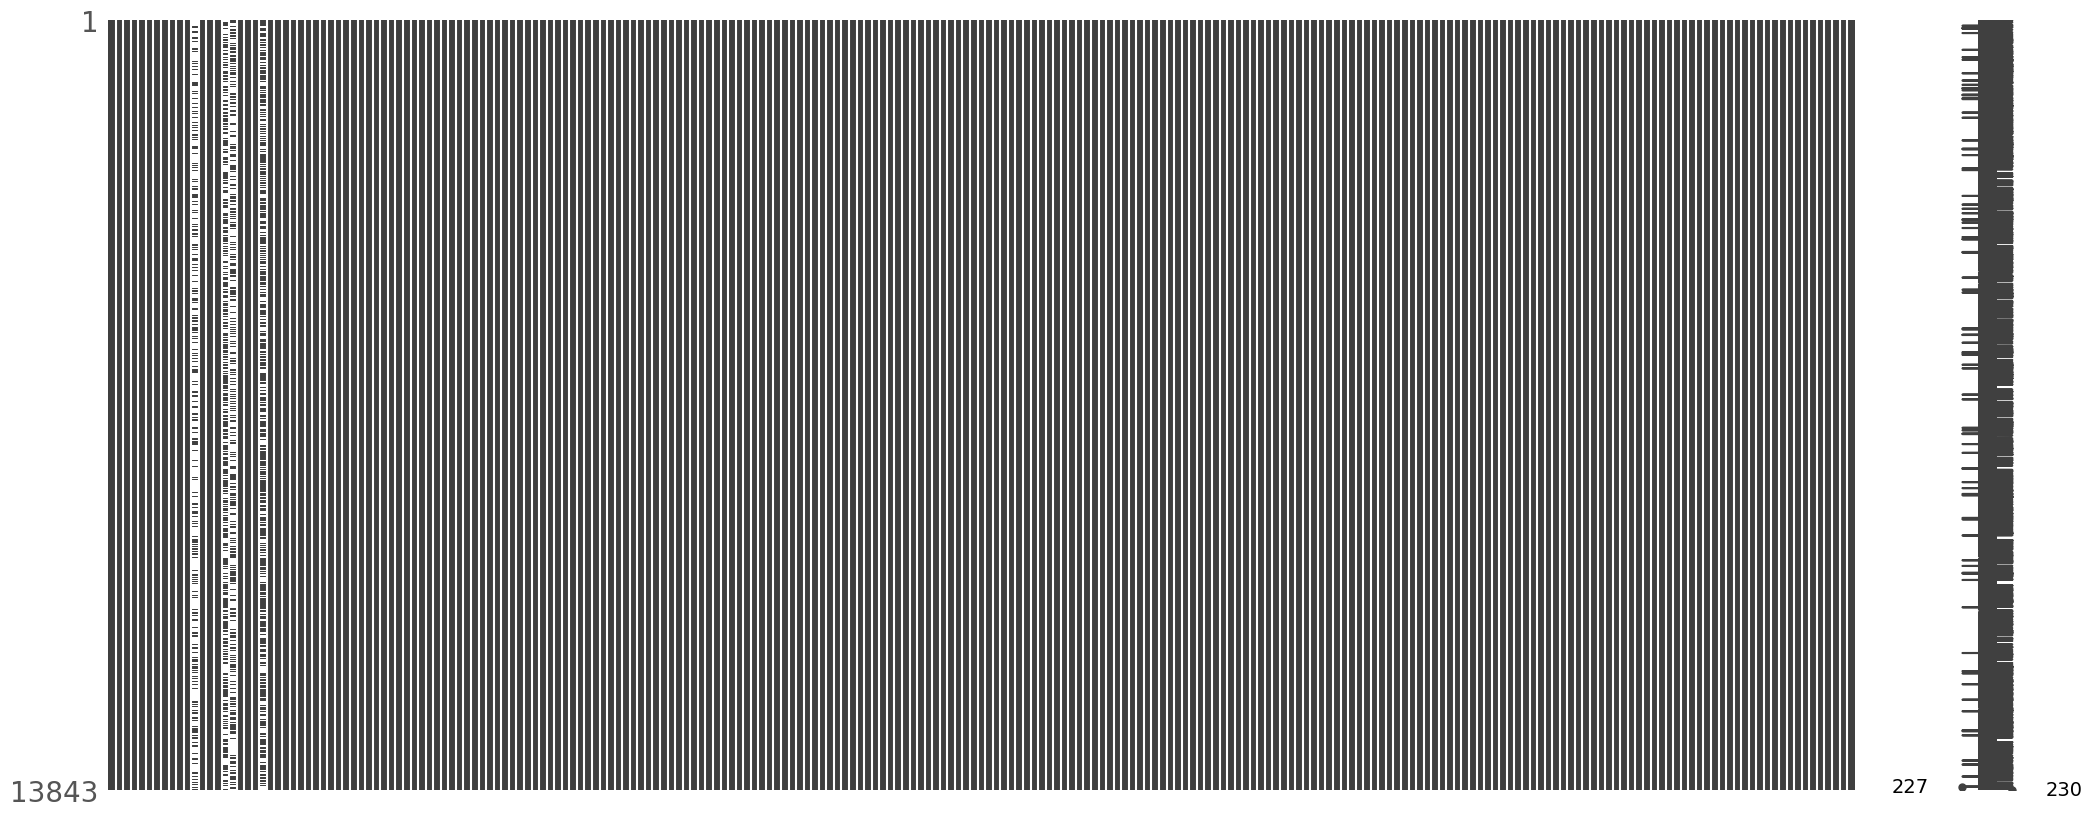

In [469]:
# Check result
print(train_df_imputed['PP14 Wong Sawang MRT'].unique())
print(train_df_imputed['Lift lobby'].unique())
print(train_df_imputed.shape)
msno.matrix(train_df_imputed);

In [470]:
# Dummified

train_df_imputed = pd.get_dummies(train_df_imputed, columns=['dist_subdist', 'property_type'], drop_first=True, dtype=int)

# Modelling

[dtype('float64') dtype('int64') dtype('int32')]


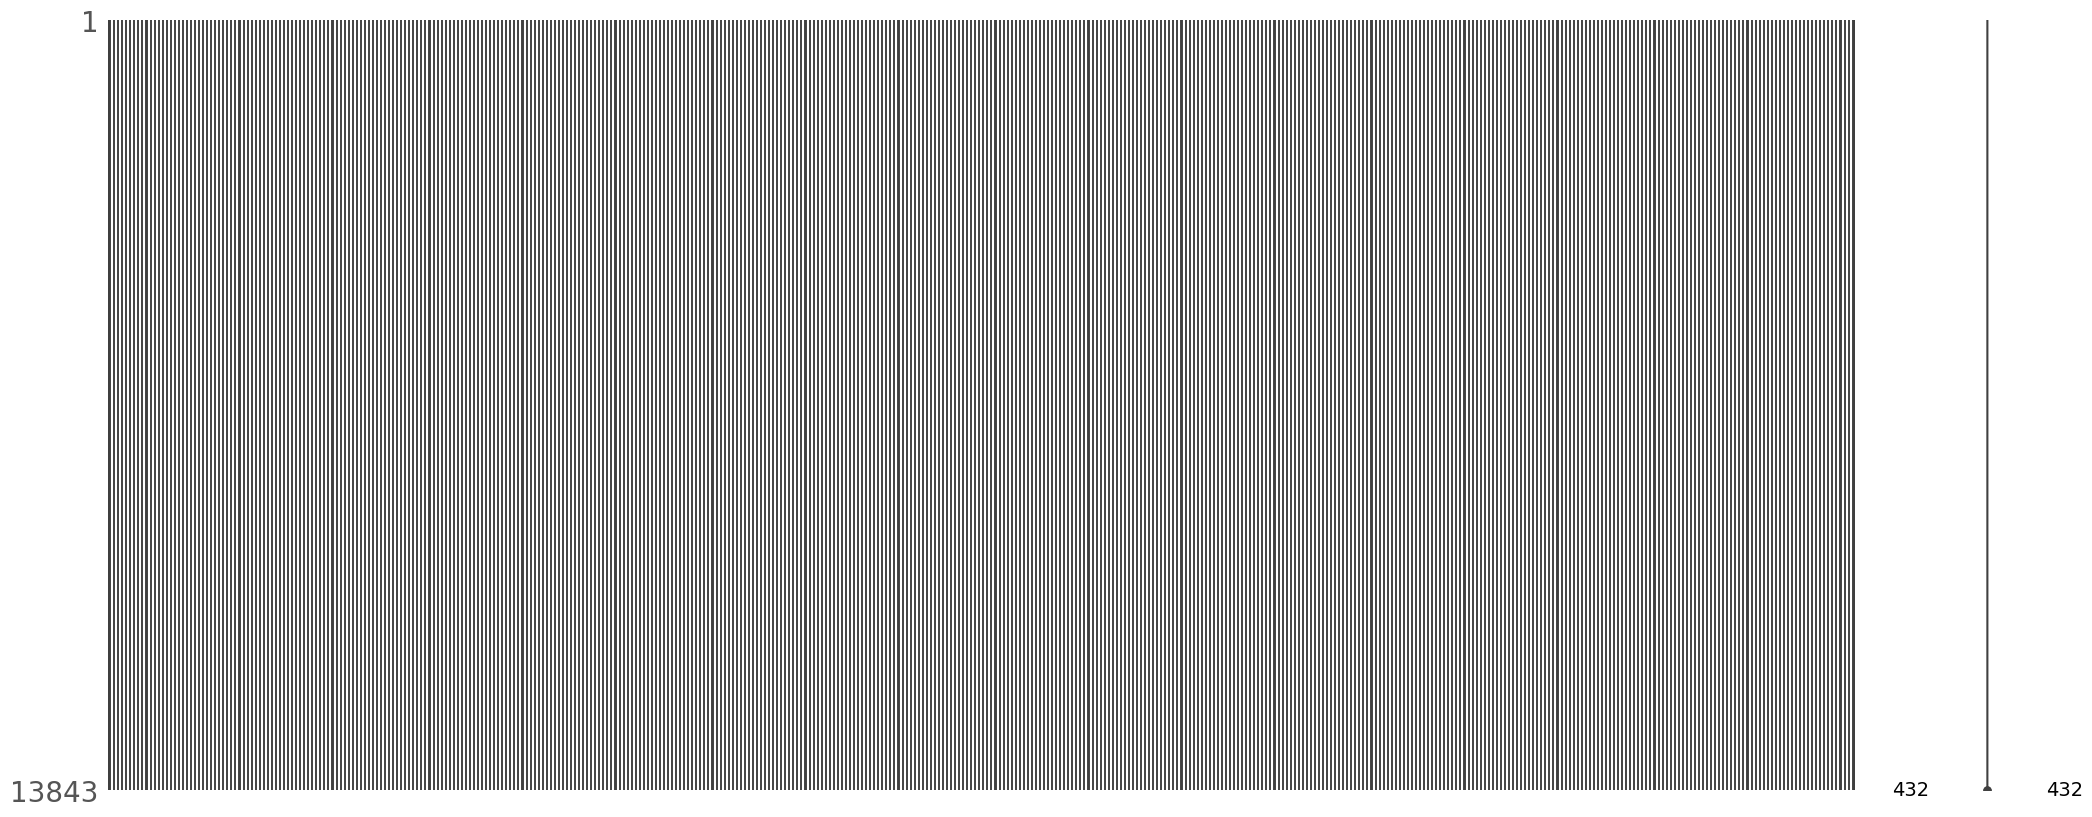

In [471]:
# Feature Selection
features = train_df_imputed.drop(columns=['price', 'nearby_station_distance', 'nearby_stations', 'facilities', 'id', 'address', 'province', 'district', 'subdistrict', 'month_built', 'latitude', 'longitude', 'land_area', 'nearby_bus_stops']).columns
y = train_df_imputed['price']
X = train_df_imputed[features]
print(X.dtypes.unique())
msno.matrix(X);

In [472]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11074, 432), (2769, 432), (11074,), (2769,))

In [473]:
# Scale
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

In [474]:
# Create model
lr = LinearRegression()
ridge = RidgeCV(alphas=np.linspace(0.1, 10, 100))
lasso = LassoCV(n_alphas=100)

In [475]:
# Check Cross Val Score
print('Lr =', cross_val_score(lr, X_train_scaled, y_train, cv=5).mean())
print('Ridge =', cross_val_score(ridge, X_train_scaled, y_train, cv=5).mean())
print('Lasso =', cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean())

Lr = -4.1615569260790175e+25
Ridge = 0.6884726046792975
Lasso = 0.6913750032378693


In [476]:
# Train & Validate
lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

print('Linear train score:', lr.score(X_train_scaled, y_train))
print('Ridge train score:', ridge.score(X_train_scaled, y_train))
print('Lasso train score:', lasso.score(X_train_scaled, y_train))

print('Linear test score:', lr.score(X_val_scaled, y_val))
print('Ridge test score:', ridge.score(X_val_scaled, y_val))
print('Lasso test score:', lasso.score(X_val_scaled, y_val))

Linear train score: 0.7203072952891798
Ridge train score: 0.7203037678438049
Lasso train score: 0.7181978422839034
Linear test score: -2.636909161047286e+20
Ridge test score: 0.6885352142606065
Lasso test score: 0.6914738620661671


In [477]:
# Check RMSE
lr_pred = lr.predict(X_val_scaled)
ridge_pred = ridge.predict(X_val_scaled)
lasso_pred = lasso.predict(X_val_scaled)

print('Lr =', np.sqrt(mean_squared_error(y_val, lr_pred)))
print('Ridge =', np.sqrt(mean_squared_error(y_val, ridge_pred)))
print('Lasso =', np.sqrt(mean_squared_error(y_val, lasso_pred)))

Lr = 3.48034761233536e+16
Ridge = 1196133.116391425
Lasso = 1190477.0287061515


# Prediction

### test_df Prep

In [543]:
test_df = pd.read_json('../data/test.json')

In [544]:
# Impute missing value

# Impute total_units with indicator
col_imputed_with_ind = knn_imp.transform(test_df[['total_units']])
test_df['total_units'] = col_imputed_with_ind[:,0]
test_df['total_units_missing'] = col_imputed_with_ind[:,1]

# Impute bedrooms, baths and nearby_supermarkets
col_imputed_with_ind = knn_imp_2.transform(test_df[['bedrooms', 'baths', 'nearby_supermarkets']])
test_df['bedrooms'] = col_imputed_with_ind[:,0]
test_df['baths'] = col_imputed_with_ind[:,1]
test_df['nearby_supermarkets'] = col_imputed_with_ind[:,2]

# Impute floor_level using mean of each category
test_df = test_df.apply(impute_floor_level_with_indicator, axis=1)


# Correcting and transform district and subdistrict
test_df['dist_subdist'] = test_df['district'] + '_' + test_df['subdistrict'].map(lambda x: '' if x == None else x)
test_df['dist_subdist'] = test_df['dist_subdist'].replace(replacement_dict)

In [545]:
test_df.loc[test_df['subdistrict'].isna(), ['district', 'subdistrict', 'dist_subdist']]

,district,subdistrict,dist_subdist
540,Phra Khanong,None,Phra Khanong_Bang Chak
1448,Sathon,None,Sathon_Thung Maha Mek
1993,Phra Khanong,None,Phra Khanong_Bang Chak


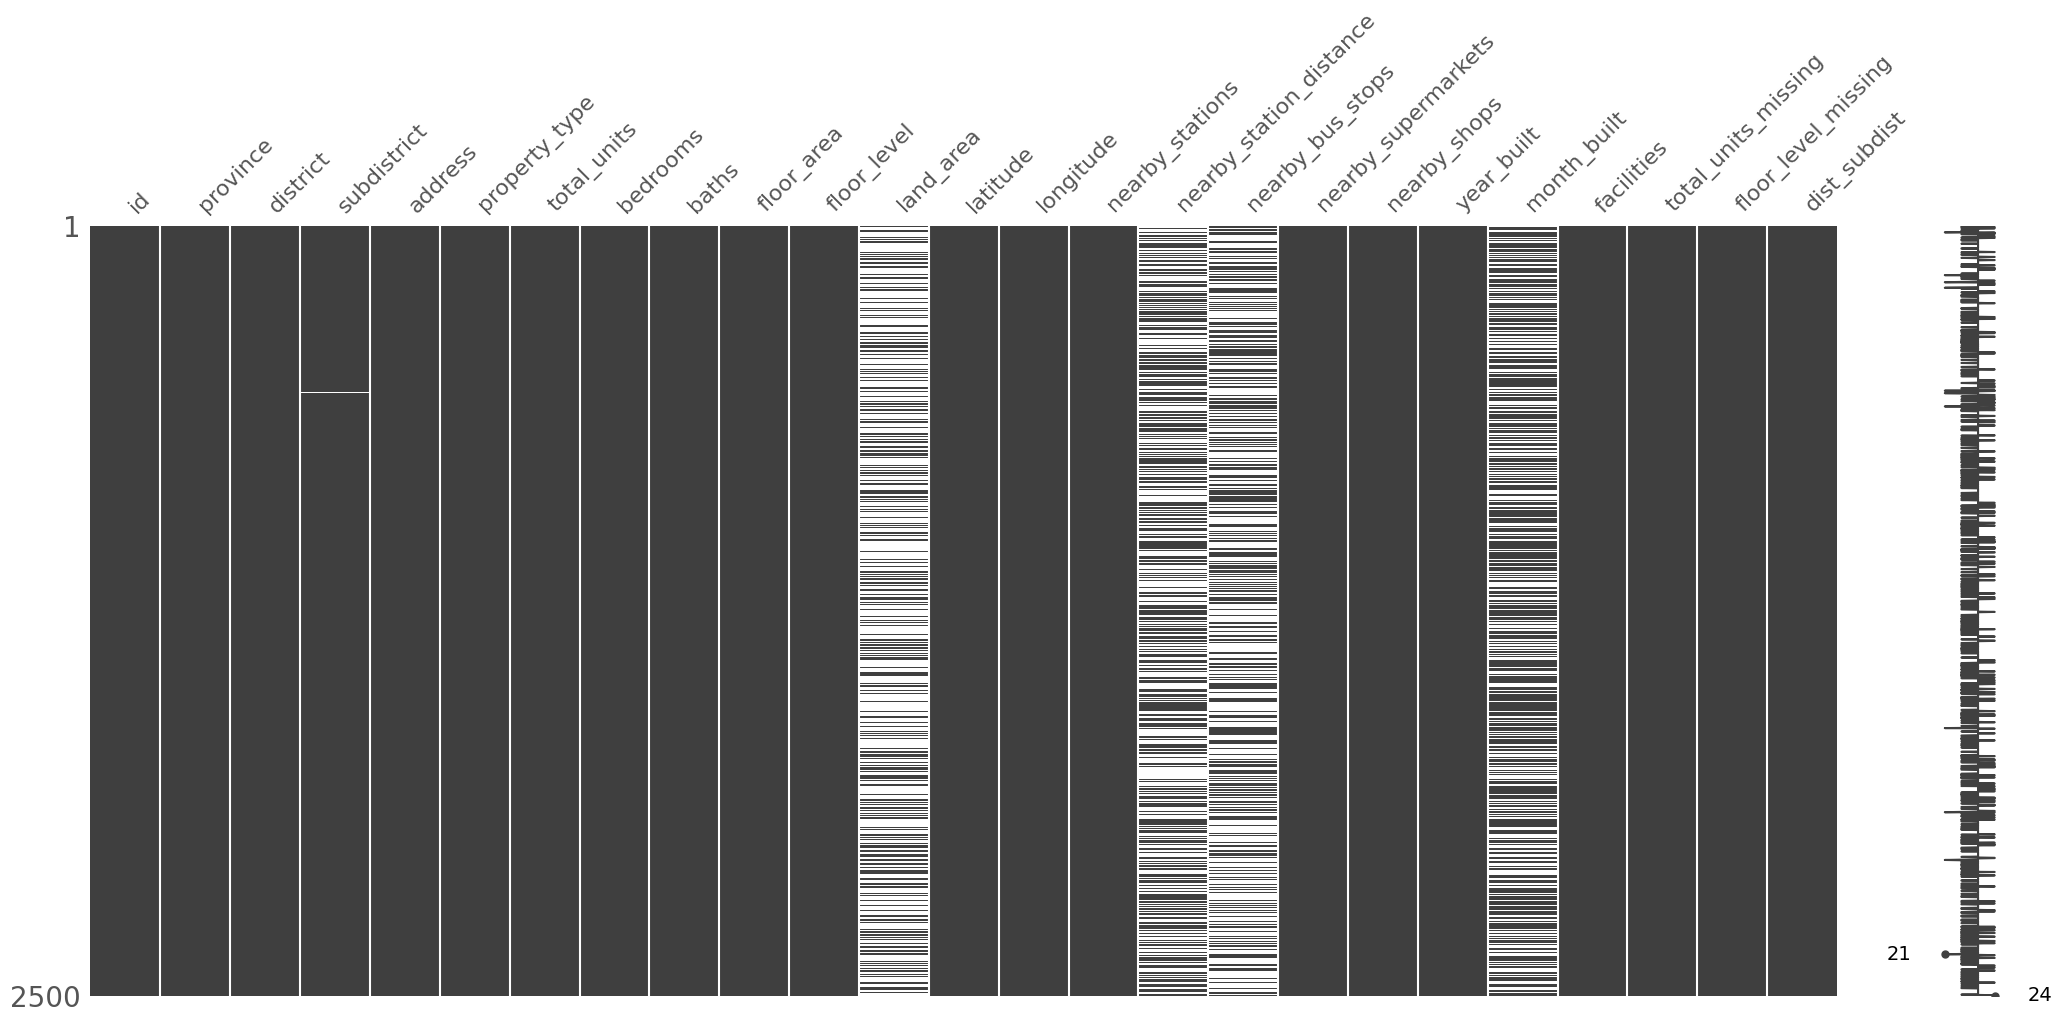

In [546]:
msno.matrix(test_df);

In [547]:
# Dummified

# Set inital value of station columns = 0
for station in station_list:
    test_df[station] = 0

# Convert nearby station and its distance to column
test_df = test_df.apply(extract_and_convert_nearby_station_to_column, axis=1)

# Set inital value of facilities columns = 0
for facility in facilities_list:
    test_df[facility] = 0

# Convert facilities to column
test_df = test_df.apply(extract_and_convert_facilities_to_column, axis=1)

# Dummified others
test_df = pd.get_dummies(test_df, columns=['dist_subdist', 'property_type'], drop_first=True, dtype=int)

C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\2564033476.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[station] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\2564033476.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[station] = 0
C:\Users\icyge\AppData\Local\Temp\ipykernel_27708\2564033476.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

### Run model & predict

In [548]:
test_df, _ = test_df.align(train_df_imputed, axis=1, fill_value=0)
test_df = pd.DataFrame(test_df)

In [549]:
X_test = test_df[features]

In [550]:
# Scale
ss = StandardScaler()
X_test_scaled = ss.fit_transform(X_test)

In [551]:
# predict
y_pred = lasso.predict(X_test_scaled)

In [552]:
# Result df
result_df = pd.concat([test_df['id'], pd.DataFrame(y_pred)], axis=1)
result_df.columns = ['id', 'price']
result_df

,id,price
0,10317868,5.436305e+06
1,10885829,6.498450e+06
2,10765951,4.782445e+06
3,10003549,5.519840e+06
4,10663026,2.441038e+06
...,...,...
2495,10889363,5.157196e+06
2496,10975839,6.827145e+06
2497,10986832,2.104105e+06
2498,10687627,2.029083e+06


In [553]:
result_df.to_csv('../data/submission.csv', index=False)